# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa19.github.io/assignments2019/assignment1/) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
## IF YOU ARE USING COLAB, UNCOMMENT AND RUN THIS BLOCK FIRST ###

# Mount google drive to allow access to your files
from google.colab import drive
drive.mount('/content/drive')
drive_folder = '/content/drive/MyDrive'
# Ajust this line to be the assignment1 folder in your google drive
notebook_folder = drive_folder + '/cs682/assignment1'
%cd {notebook_folder}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cs682/assignment1


In [2]:
from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'
    # Don't forget to run get_datasets.sh, or this will throw an error
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs682/classifiers/softmax.py**.


In [4]:
# -np.log(0.1)

In [5]:

# np.random.randn(3073, 10).max() * .0001

In [6]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs682/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs682.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.437405
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** The W Weights are instantiated with 10 random small values, so the calculated scores will also be 10 random values. The correct score is going to be 1 out of the sum of all 10 classes. In the first iteration of the scores calculation and unadjusted weights, this is going to be roughly .1 without gradients which is why within the negative logarithm we have 0.1. The negative logarithm is applied as the Loss function for Softmax is evaluated.

In [7]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs682.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.033467 analytic: 1.033467, relative error: 1.192458e-08
numerical: 0.294033 analytic: 0.294033, relative error: 3.301996e-08
numerical: 0.199888 analytic: 0.199888, relative error: 2.624537e-07
numerical: -2.759634 analytic: -2.759634, relative error: 2.626769e-09
numerical: -0.607240 analytic: -0.607240, relative error: 5.129649e-08
numerical: -0.990035 analytic: -0.990035, relative error: 3.493796e-09
numerical: 2.044668 analytic: 2.044668, relative error: 2.103107e-08
numerical: -0.249467 analytic: -0.249467, relative error: 1.310402e-07
numerical: 3.392682 analytic: 3.392682, relative error: 2.782270e-08
numerical: 0.478372 analytic: 0.478372, relative error: 2.290934e-08
numerical: 0.794986 analytic: 0.794986, relative error: 5.389514e-08
numerical: -3.609989 analytic: -3.609989, relative error: 7.326766e-09
numerical: -2.211248 analytic: -2.211248, relative error: 5.246423e-09
numerical: 1.483773 analytic: 1.483773, relative error: 9.821687e-09
numerical: -5.447092 a

In [8]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs682.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.437405e+00 computed in 0.132770s
vectorized loss: 2.437405e+00 computed in 0.014152s
Loss difference: 0.000000
Gradient difference: 0.000000


In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs682.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
# learning_rates = [1e-8, 1e-7, 5e-6]
learning_rates = [1e-7, 5e-6]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# train Softmax model on X_val
for lr in learning_rates:
    for rs in regularization_strengths:

      print("learning rate:", lr, "reg strength", rs)

      softmax_tune = Softmax()
      loss_hist = softmax_tune.train(X_train, y_train, learning_rate=lr, reg=rs,
                            num_iters=1500, verbose=True)

      # evaluate the performance on both the training and validation set
      y_train_pred_tune = softmax_tune.predict(X_train)
      train_tune_acc = np.mean(y_train == y_train_pred_tune)
      print('training accuracy: %f' % (train_tune_acc, ))

      y_val_pred_tune = softmax_tune.predict(X_val)
      val_tune_acc = np.mean(y_val == y_val_pred_tune)
      print('validation accuracy: %f' % (val_tune_acc, ))

      results[(lr, rs)] = (train_tune_acc, val_tune_acc)

      # if validation accuracy value is greater than the current stored one
      # (best_val), then store it and the current SVM object
      if best_val <= val_tune_acc:
          best_val = val_tune_acc
          best_softmax = softmax_tune
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning rate: 1e-07 reg strength 25000.0
iteration 0 / 1500: loss 781.258794
iteration 100 / 1500: loss 286.968510
iteration 200 / 1500: loss 106.244115
iteration 300 / 1500: loss 40.223563
iteration 400 / 1500: loss 16.032031
iteration 500 / 1500: loss 7.185116
iteration 600 / 1500: loss 3.990104
iteration 700 / 1500: loss 2.796309
iteration 800 / 1500: loss 2.387433
iteration 900 / 1500: loss 2.175149
iteration 1000 / 1500: loss 2.149874
iteration 1100 / 1500: loss 2.048402
iteration 1200 / 1500: loss 2.073629
iteration 1300 / 1500: loss 2.062408
iteration 1400 / 1500: loss 2.066837
training accuracy: 0.323184
validation accuracy: 0.342000
learning rate: 1e-07 reg strength 50000.0
iteration 0 / 1500: loss 1550.539139
iteration 100 / 1500: loss 208.751865
iteration 200 / 1500: loss 29.785856
iteration 300 / 1500: loss 5.778069
iteration 400 / 1500: loss 2.626809
iteration 500 / 1500: loss 2.224822
iteration 600 / 1500: loss 2.165046
iteration 700 / 1500: loss 2.132324
iteration 800 /

In [10]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.336000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*: In an SVM, if a score/margin is below a certain threshold,  then that datapoint can have 0 contributed loss to the overall model. Thus, proving the first part of the statement true. In a Softmax classifier, there is no concept of a threshold below which no loss is added to the model. Loss is always added no matter what, thus adding a new datapoint to a training set will change the Softmax classifier loss.

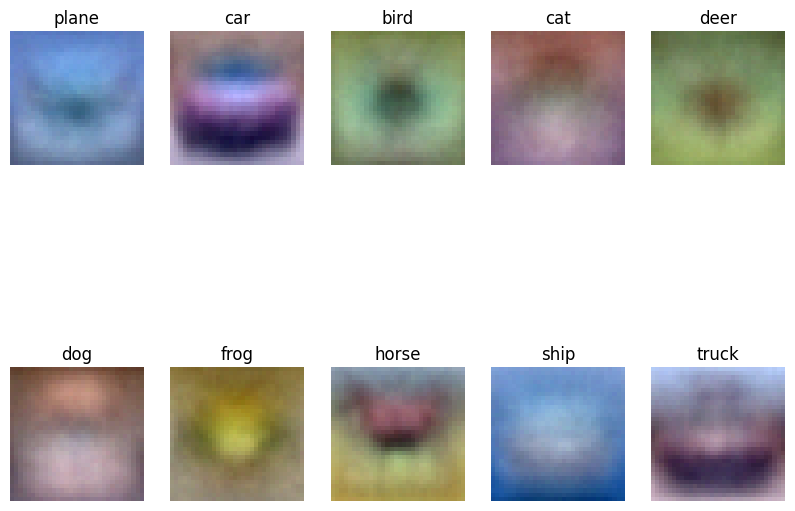

In [11]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])